In [2]:
"""

Purpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"
    and compare its performance to simple confidence thresholding on a logistic regression classifier.

Following https://builtin.com/data-science/guide-logistic-regression-tensorflow-20

--- Following Josh's placeholders_experiments.ipynb to create a version that works with text data

"""

'\nPurpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"\n    and compare its performance to simple confidence thresholding on a logistic regression classifier.\n\nFollowing https://builtin.com/data-science/guide-logistic-regression-tensorflow-20\n'

In [3]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [40]:
NUM_CLASSES = 100

def load_dataset():
    df = pd.read_excel(r'/content/drive/MyDrive/NLP_Fall2022/Group Project/DatasetSplit/train_split.xlsx', usecols=['label','review'])
    df_test = pd.read_excel(r'/content/drive/MyDrive/NLP_Fall2022/Group Project/DatasetSplit/test_split.xlsx', usecols=['label','review'])
    # tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.object)
    # X_train = tf.convert_to_tensor(df['review'])
    # y_train = tf.convert_to_tensor(df['label'])
    # X_test = tf.convert_to_tensor(df_test['review'])
    # y_test = tf.convert_to_tensor(df_test['label'])

    X_train = df['review']
    y_train = df['label']
    X_test = df_test['review']
    y_test = df_test['label']
    return X_train, y_train, X_test, y_test

def validation_split(X, y, val_size=.2):
    """Input are expected to be tensors.
    """
    # tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.float32)
    X_train, X_val, y_train, y_val = train_test_split(X, y)
    return X_train, X_val, y_train, y_val

In [41]:
X, y, X_test, y_test = load_dataset()

In [42]:
def plot_loss(train_losses, val_losses):
    iterations = list(range(len(train_losses)))
    plt.plot(iterations, train_losses, label='Train')
    plt.plot(iterations, val_losses, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.title('Loss While Training')
    plt.show()
    
def plot_acc(train_accs, val_accs):
    iterations = list(range(len(train_accs)))
    plt.plot(iterations, train_accs, label='Train')
    plt.plot(iterations, val_accs, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel('Classification Accuracy')
    plt.legend()
    plt.title('Accuracy While Training')
    plt.show()

In [117]:
class StandardLogisticRegressionModel(tf.keras.Model):
    def __init__(self, pre_dim, post_dim, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.embed_pre = tf.keras.layers.Dense(pre_dim,  activation='relu', name='embed_pre')
        self.embed_post = tf.keras.layers.Dense(post_dim, activation='relu', name='embed_post')
        self.logits_layer = tf.keras.layers.Dense(num_classes, activation=None, name='ligits')
        self.output_layer = tf.keras.layers.Softmax(name='output')
        
    # def call(self, inputs):
    #     print("2nd layer\n\n")
    #     print(inputs)
    #     x_pre = self.embed_pre(inputs)
    #     print(x_pre)
    #     x_post = self.embed_post(x_pre)
    #     print(x_post)
    #     logits = self.logits_layer(x_post)
    #     print(logits)
    #     return self.output_layer(logits)

def ce_loss(y_true, y_pred):
    """ Cross Entropy Loss.
    y_true: one-hot encoded class labels
    y_pred: class probabilities
    """
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def accuracy(y_true, y_pred):
    """y_true is the true class labels (not one-hot encoded) and y_pred are the predicted
    class labels (not class probabilities).
    """
    correct_preds = tf.equal(tf.cast(y_true, tf.int64), y_pred)
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32))

In [52]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import np_utils
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_val, y_train, y_val = validation_split(X, y, val_size=.2)

In [ ]:

epochs = 500
batch_size = 64

vectorizer = TfidfVectorizer(max_features=250, sublinear_tf=True, ngram_range=(1,2))
train_features = vectorizer.fit_transform(X_train).toarray()
dev_features = vectorizer.transform(X_val).toarray()
# y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=100)
lb = LabelEncoder()
ytrain = lb.fit_transform(y_train)
dummy_y_train = np_utils.to_categorical(ytrain)

yval = lb.fit_transform(y_val)
dummy_y_dev = np_utils.to_categorical(yval)

In [62]:
pre_dim = post_dim = 200
model = StandardLogisticRegressionModel(
    pre_dim=pre_dim, 
    post_dim=post_dim, 
    num_classes=NUM_CLASSES
)
model.compile(
    optimizer='adam', 
    loss=ce_loss, 
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')]
)
# y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes)

# history = model.fit(X, y_train_one_hot, epochs=10, validation_split=.2)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(train_features, dummy_y_train, batch_size=batch_size,
                  callbacks=[es_callback],
          epochs=epochs, validation_data=(dev_features, dummy_y_dev))
# history = model.fit(X, y_train_one_hot, epochs=10, validation_split=.2)

Epoch 1/500
557/557 [==============================] - 4s 6ms/step - loss: 3.4490 - acc: 0.2171 - val_loss: 2.6419 - val_acc: 0.3649
Epoch 2/500
557/557 [==============================] - 3s 6ms/step - loss: 2.2845 - acc: 0.4447 - val_loss: 2.1759 - val_acc: 0.4607
Epoch 3/500
557/557 [==============================] - 3s 6ms/step - loss: 1.9257 - acc: 0.5200 - val_loss: 1.9745 - val_acc: 0.5043
Epoch 4/500
557/557 [==============================] - 3s 6ms/step - loss: 1.7345 - acc: 0.5644 - val_loss: 1.8410 - val_acc: 0.5346
Epoch 5/500
557/557 [==============================] - 5s 8ms/step - loss: 1.6012 - acc: 0.5943 - val_loss: 1.7740 - val_acc: 0.5496
Epoch 6/500
557/557 [==============================] - 3s 5ms/step - loss: 1.5008 - acc: 0.6156 - val_loss: 1.7230 - val_acc: 0.5619
Epoch 7/500
557/557 [==============================] - 3s 6ms/step - loss: 1.4186 - acc: 0.6350 - val_loss: 1.6957 - val_acc: 0.5679
Epoch 8/500
557/557 [==============================] - 3s 6ms/step - 

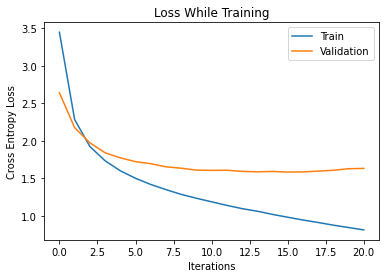

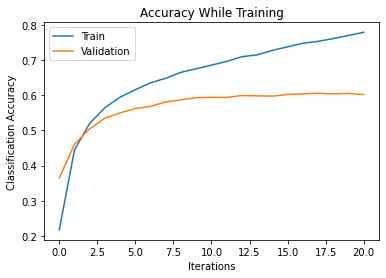

In [63]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_loss(train_loss, val_loss)

train_acc = history.history['acc']
val_acc = history.history['val_acc']
plot_acc(train_acc, val_acc)

In [66]:

# from matplotlib import pyplot
# pyplot.plot(history.history['loss'])
# pyplot.plot(history.history['val_loss'])
# pyplot.title('model train vs validation loss')
# pyplot.ylabel('loss')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'validation'], loc='upper left')
# pyplot.show()
# pyplot.plot(history.history['accuracy'])
# pyplot.plot(history.history['val_accuracy'])
# pyplot.title('model train vs validation acc')
# pyplot.ylabel('acc')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'validation'], loc='upper left')
# pyplot.show()
# score = model.evaluate(dev_features, dummy_y_dev, batch_size=batch_size, verbose=1)





# test_features = vectorizer.fit_transform(X_test).toarray()

# y_testval = lb.fit_transform(y_test)
# dummy_y_test = np_utils.to_categorical(y_testval)
# #Predictions 
# print ("Predict")
# y_test1 = model.predict(test_features)

# y_pred = lb.inverse_transform(np.argmax(y_test1, axis=1))


# score = model.evaluate(test_features, dummy_y_test, batch_size=batch_size, verbose=1)

# print('Test accuracy:', score[1])

In [103]:
""" 
Now we attempt open-set classicfication by training a logistic regression model on k 
classes (digits 0-8 for this dataset) and test on k+1. If all predicted class probabilities
are below a threshold, predict the open set.
"""
from itertools import compress
    
def threshold_predict(X, model, threshold):
    # print(X)
    # y_pred = model.call(X)
    y_pred = model.predict(X)
    # print(y_pred)
    highest_prob = tf.reduce_max(y_pred, axis=1)
    return tf.where(highest_prob < threshold, -1, tf.argmax(y_pred, axis=1))

def remove_classes_from_dataset(X, y, class_labels):
    """Removes samples from both X and y that correspond to classes given in class_labels
    class_labels: list of class_labels e.g. [3,4,9]
    y: tensor containing class labels (not yet one-hot encoded)
    """
    to_remove_mask = [y != label for label in class_labels]
    X = np.array(X) 
    result = X[to_remove_mask] 
    X=result.tolist()
    y = np.array(y) 
    result = y[to_remove_mask] 
    y=result.tolist()
    return X, y

def modify_open_set_labels(y, open_set_class_labels):
    """Replaces class labels from the open set in y with -1
    """
    open_set_idx = tf.reduce_any([y == label for label in open_set_class_labels], axis=0)
    return tf.where(open_set_idx, -1, y)

def open_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    open_set_idx = y_true == -1
    return accuracy(y_true[open_set_idx], y_pred[open_set_idx])

def closed_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    closed_set_idx = y_true != -1
    return accuracy(y_true[closed_set_idx], y_pred[closed_set_idx])
    #return tf.reduce_sum(tf.equal(y_true[closed_set_idx], y_pred[closed_set_idx]))

def plot_open_closed_accuracy(all_acc, open_acc, closed_acc):
    plt.plot(threshold_value, all_acc, label='All class accuracy')
    plt.plot(threshold_value, open_acc, label='Open set accuracy')
    plt.plot(threshold_value, closed_acc, label='Closed set accuracy')
    plt.xlabel('Classification Probability Threshold')
    plt.ylabel('Classification Accuracy')
    plt.legend()
    plt.title('Effect of Threshold on Accuracy')
    plt.show()

In [89]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [99] 

X_train, X_val, y_train, y_val = validation_split(X, y)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)
X_val_closed, y_val_closed = remove_classes_from_dataset(X_val, y_val, open_set_class_labels)


pre_dim = post_dim = 200
model = StandardLogisticRegressionModel(pre_dim, post_dim, NUM_CLASSES - 1)
model.compile(optimizer='adam', loss=ce_loss, metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')])





train_features = vectorizer.fit_transform(X_train_closed).toarray()
dev_features = vectorizer.transform(X_val_closed).toarray()

lb = LabelEncoder()
ytrain = lb.fit_transform(y_train_closed)
dummy_y_train = np_utils.to_categorical(ytrain)

yval = lb.fit_transform(y_val_closed)
dummy_y_dev = np_utils.to_categorical(yval)


es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(train_features, dummy_y_train, batch_size=batch_size,
                  callbacks=[es_callback],
          epochs=epochs, validation_data=(dev_features, dummy_y_dev))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1/500
551/551 [==============================] - 4s 6ms/step - loss: 3.4177 - acc: 0.2272 - val_loss: 2.6180 - val_acc: 0.3693
Epoch 2/500
551/551 [==============================] - 3s 6ms/step - loss: 2.2901 - acc: 0.4385 - val_loss: 2.1527 - val_acc: 0.4678
Epoch 3/500
551/551 [==============================] - 3s 6ms/step - loss: 1.9474 - acc: 0.5123 - val_loss: 1.9053 - val_acc: 0.5268
Epoch 4/500
551/551 [==============================] - 3s 6ms/step - loss: 1.7432 - acc: 0.5607 - val_loss: 1.8082 - val_acc: 0.5458
Epoch 5/500
551/551 [==============================] - 3s 6ms/step - loss: 1.6101 - acc: 0.5901 - val_loss: 1.7224 - val_acc: 0.5669
Epoch 6/500
551/551 [==============================] - 3s 6ms/step - loss: 1.5080 - acc: 0.6137 - val_loss: 1.6605 - val_acc: 0.5805
Epoch 7/500
551/551 [==============================] - 3s 5ms/step - loss: 1.4298 - acc: 0.6296 - val_loss: 1.6423 - val_acc: 0.5838
Epoch 8/500
551/551 [==============================] - 3s 6ms/step - 

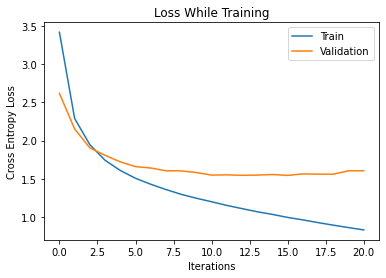

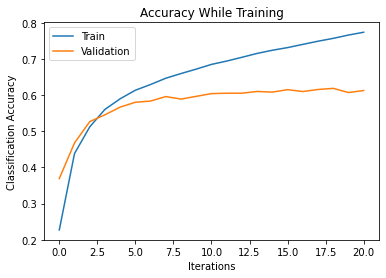

In [90]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_loss(train_loss, val_loss)

train_acc = history.history['acc']
val_acc = history.history['val_acc']
plot_acc(train_acc, val_acc)

79/79 [==============================] - 0s 2ms/step


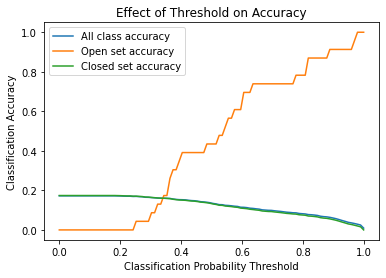

total accuracy:      0.1724
open-set accuracy:   0.0000
closed-set accuracy: 0.1740
optimal threshold:   0.0000


In [104]:

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)


# See how the threshold value affects open-set accuracy
threshold_value = np.linspace(0, 1, 100)

total_acc = []
open_set_acc = []
closed_set_acc = []

max_total_acc = 0
best_threshold = 0

for threshold in threshold_value:
    test_features = vectorizer.fit_transform(X_test).toarray()
    y_pred = threshold_predict(test_features, model, threshold)
    total_acc.append(accuracy(y_test_open, y_pred))
    open_set_acc.append(open_set_accuracy(y_test_open, y_pred))
    closed_set_acc.append(closed_set_accuracy(y_test_open, y_pred))
    
plot_open_closed_accuracy(total_acc, open_set_acc, closed_set_acc)

best_total_acc_idx = np.argmax(total_acc)
print('total accuracy:      {:.4f}'.format(float(total_acc[best_total_acc_idx])))
print('open-set accuracy:   {:.4f}'.format(float(open_set_acc[best_total_acc_idx])))
print('closed-set accuracy: {:.4f}'.format(float(closed_set_acc[best_total_acc_idx])))
print('optimal threshold:   {:.4f}'.format(float(threshold_value[best_total_acc_idx])))

In [124]:
""" Now that we have a baseline, we will implement the placeholders algorithm.
"""

class OpenSetPlaceholdersLRM(StandardLogisticRegressionModel):
    def __init__(self, num_placeholders, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_placeholders = num_placeholders
        self.dummy_logits_layer = tf.keras.layers.Dense(num_placeholders, activation=None, name='dummy_logits')

    def call(self, inputs):
        x_pre = self.embed_pre(inputs)
        x_post = self.embed_post(x_pre)
        closed_set_logits = self.logits_layer(x_post)
        dummy_logits = self.dummy_logits_layer(x_post)
        max_dummy_logit = tf.reduce_max(dummy_logits, axis=1)
        all_logits = tf.concat([closed_set_logits, tf.expand_dims(max_dummy_logit, 1)], axis=1)
        return self.output_layer(all_logits)
        
    def predict(self, x):
        """ Returns the predicted class label. If predicted class is dummy class, return -1
        indicating prediction falls within the open set.
        """
        y_pred = self.__call__(x)
        y_pred_labels = tf.argmax(y_pred, axis=1)
        return tf.where(y_pred_labels == self.num_classes, -1, y_pred_labels)
    
def ce_loss_for_placeholders(y_true, y_pred, beta):
    loss = ce_loss(y_true, y_pred)
    # set each sample's predicted probability for the true class to zero
    y_pred_without_true_prob = tf.where(y_true == 1, 0., y_pred)
    # create a new y_true where the true label is the dummy class
    rows, cols = y_true.shape
    rows = rows or 1
    y_true_dummy = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
    loss += beta * ce_loss(y_true_dummy, y_pred_without_true_prob)
    return loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1/500
551/551 [==============================] - 6s 9ms/step - loss: 5.1409 - acc: 0.0078 - val_loss: 4.2088 - val_acc: 0.0301
Epoch 2/500
551/551 [==============================] - 4s 8ms/step - loss: 3.7985 - acc: 0.0931 - val_loss: 3.6048 - val_acc: 0.1280
Epoch 3/500
551/551 [==============================] - 5s 8ms/step - loss: 3.3659 - acc: 0.1737 - val_loss: 3.3505 - val_acc: 0.1923
Epoch 4/500
551/551 [==============================] - 4s 8ms/step - loss: 3.1593 - acc: 0.2150 - val_loss: 3.2433 - val_acc: 0.2429
Epoch 5/500
551/551 [==============================] - 4s 8ms/step - loss: 3.0228 - acc: 0.2442 - val_loss: 3.1537 - val_acc: 0.2162
Epoch 6/500
551/551 [==============================] - 4s 8ms/step - loss: 2.9236 - acc: 0.2640 - val_loss: 3.0973 - val_acc: 0.2480
Epoch 7/500
551/551 [==============================] - 4s 8ms/step - loss: 2.8427 - acc: 0.2808 - val_loss: 3.0525 - val_acc: 0.2556
Epoch 8/500
551/551 [==============================] - 5s 9ms/step - 

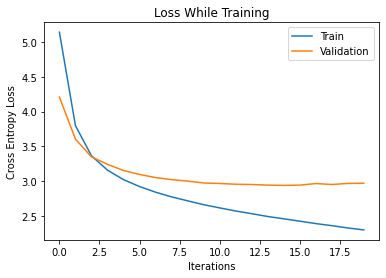

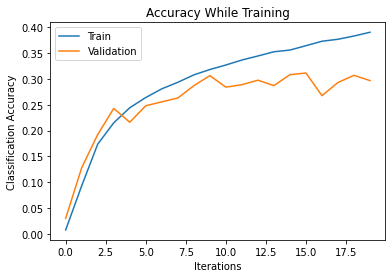

In [106]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [99] 

X_train, X_val, y_train, y_val = validation_split(X, y)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)
X_val_closed, y_val_closed = remove_classes_from_dataset(X_val, y_val, open_set_class_labels)


num_placeholders = 120
pre_dim = post_dim = 200
model = OpenSetPlaceholdersLRM(
    pre_dim=pre_dim, 
    post_dim=post_dim, 
    num_classes=NUM_CLASSES - 1,
    num_placeholders=num_placeholders
)
beta = .75
loss = lambda *x: ce_loss_for_placeholders(*x, beta)
model.compile(
    optimizer='adam', 
    loss=loss, 
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')]
)


# The "+ 1"s below add an additional column of zeros to the one-hot encodings for
# the dummy class
train_features = vectorizer.fit_transform(X_train_closed).toarray()
dev_features = vectorizer.transform(X_val_closed).toarray()


y_train_one_hot = tf.one_hot(y_train_closed, depth=model.num_classes + 1)
y_val_one_hot = tf.one_hot(y_val_closed, depth=model.num_classes + 1)


es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(train_features, y_train_one_hot, batch_size=batch_size,
                  callbacks=[es_callback],
          epochs=epochs, validation_data=(dev_features, y_val_one_hot))


# y_train_one_hot = tf.one_hot(tf.cast(y_train_closed, tf.int64), depth=model.num_classes + 1)
# history = model.fit(X_train_closed, y_train_one_hot, epochs=20, validation_split=.2, batch_size=32)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_loss(train_loss, val_loss)

train_acc = history.history['acc']
val_acc = history.history['val_acc']
plot_acc(train_acc, val_acc)

Under progress from here onwards

In [126]:
total_acc = []
open_set_acc = []
closed_set_acc = []

y_pred = model.predict(X_val)

print('total accuracy:      {:.4f}'.format(accuracy(y_val_open, y_pred)))
print('open-set accuracy:   {:.4f}'.format(open_set_accuracy(y_val_open, y_pred)))
print('closed-set accuracy: {:.4f}'.format(closed_set_accuracy(y_val_open, y_pred)))

AttributeError: ignored